<a href="https://colab.research.google.com/github/CoreTheGreat/HBPU-Machine-Learning-Course/blob/main/ML_Chapter2_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第二章：回归
湖北理工学院《机器学习》课程资料

作者：李辉楚吴

笔记内容概述:
* 2.1 绕不开的房价预测：准备房价预测数据
* 2.2 用线性回归预测房价
* 2.3 梯度下降 Gradient Descend
* 2.4 模型泛化 Generalization


## 2.1 绕不开的房价预测

步骤1：从 http://lib.stat.cmu.edu/datasets/boston 导入房价预测数据

原始数据是一个列数为11的矩阵。每两行内容为一条记录，包含描述房屋的13种特征以及房屋价格。

In [ ]:
import pandas as pd # To load house price data
import numpy as np # To manipulate data

data_url = 'http://lib.stat.cmu.edu/datasets/boston' # Set url of the dataset
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22, header=None) # Load data
raw_df.head(10) # Display the raw data

,0,1,2,3,4,5,6,7,8,9,10
0,0.00632,18.00,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3
1,396.90000,4.98,24.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02731,0.00,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8
3,396.90000,9.14,21.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.02729,0.00,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8
5,392.83000,4.03,34.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.03237,0.00,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7
7,394.63000,2.94,33.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.06905,0.00,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7
9,396.90000,5.33,36.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


步骤2：重构数据，将原始数据分为一个特征矩阵 (data) 和房价向量 (target)。

注意：特征矩阵的记录数量应与房价数量相同。

特征描述：

* [0] - 按城镇划分的犯罪率
* [1] - 面积超过25,000平方英尺（2322.58平方米）的住宅用地占比
* [2] - 非零售商业用地占比
* [3] - 是否位于查尔斯河畔 ( 1为是，0为否 )
* [4] - 氮氧化物浓度（空气质量） (单位：ppm)
* [5] - 每个住宅的平均房间数
* [6] - 1940年以前建造的自住房比例
* [7] - 到波士顿五个就业中心的加权距离
* [8] - 辐射路可达性指数
* [9] - 每10,000美元的房产税率
* [10] - 学生-教师比率
* [11] - （忽略） 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* [12] - 低层次人口占比

房价描述:
* 自住房房价中位数（单位：千美元）

In [ ]:
import pandas as pd

data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, 1:2]]) # Select features
target = raw_df.values[1::2, 2] # Select target

fts_names = [
    '犯罪率（%）',
    '大住宅用地占比（%）',
    '非零售商业用地占比（%）',
    '景观房',
    '氮氧化物浓度（ppm）',
    '平均房间数',
    '老旧房屋占比（%）',
    '离就业中心的加权距离',
    '辐射路可达性指标',
    '每万元房产税',
    '学生-教师比',
    '低层次人口占比（%）'] # Feature names

print(f'Data shape: {data.shape}, Target shape: {target.shape}') # Display the shape of data and target

Data shape: (506, 12), Target shape: (506,)


步骤3：用散点图（Scatter）展现各个特征与房价之间的关系。

注意：需要安装字体才能在figure中显式中文。[Colab环境中需要]

In [ ]:
!wget -O simhei.ttf 'https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf'
import matplotlib
matplotlib.font_manager.fontManager.addfont('simhei.ttf') # Add the font
matplotlib.rc('font', family='SimHei') # Set the font

--2024-08-23 08:39:19--  https://www.wfonts.com/download/data/2014/06/01/simhei/chinese.simhei.ttf
Resolving www.wfonts.com (www.wfonts.com)... 172.67.129.58, 104.21.1.127, 2606:4700:3037::6815:17f, ...
Connecting to www.wfonts.com (www.wfonts.com)|172.67.129.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10050870 (9.6M) [application/octetstream]
Saving to: ‘simhei.ttf’

simhei.ttf          100%[===================>]   9.58M  --.-KB/s    in 0.1s    

2024-08-23 08:39:19 (87.7 MB/s) - ‘simhei.ttf’ saved [10050870/10050870]



逐一完成各个特征和房价的散点图

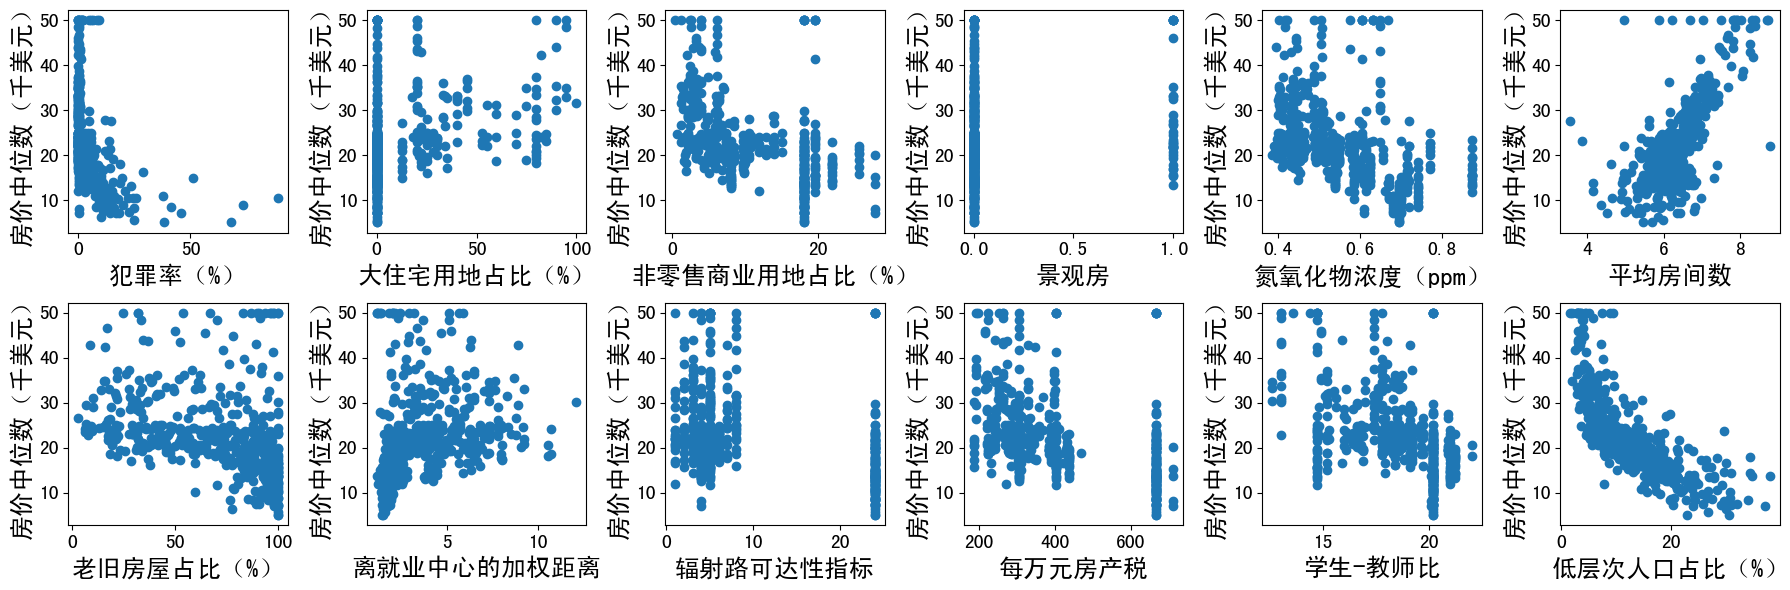

In [ ]:
import matplotlib.pyplot as plt # To draw figures

plt.rcParams['font.sans-serif'] = ['SimHei']  # Support Chinese
plt.rcParams['axes.unicode_minus'] = False  # Support negative sign

num_fts = data.shape[1] # Get the number of features
num_col = 6 # Number of columns in the figure
num_row = int(np.ceil(num_fts / num_col)) # Number of rows in the figure

label_size = 18 # Label size
ticklabel_size = 14 # Tick label size

_, axes = plt.subplots(num_row, num_col, figsize=(18, 3*num_row)) # Create a figure

for i in range(num_fts): # Loop through all features
    row = int(i / num_col) # Get the row index
    col = i % num_col # Get the column index

    ax = axes[row, col]
    ax.scatter(data[:, i], target) # Plot scatter fig of i-th feature and target
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_xlabel(fts_names[i], fontsize=label_size) # Label the x-axis
    ax.set_ylabel('房价中位数（千美元）', fontsize=label_size) # Label the y-axis

plt.tight_layout() # Adjust the layout of the figure
plt.show() # Display the figure

## 2.2 用线性回归预测房价

本节内容包括三个部分：
* 准备一大堆房价数据
* 准备一堆房价预测模型
* 选择最优的房价预测模型

### 2.2.1 准备一大堆房价数据

画出房价与房间数量的散点图，观察房价与房间数量的关系。

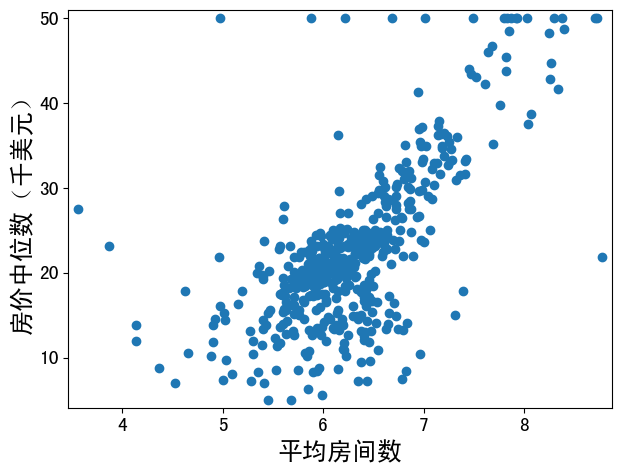

In [ ]:
x = data[:, 5] # Get the number of rooms
y = target # Get the target

def draw_scatter(x, y):
    '''
    This a specific function to draw a scatter figure of room number and house price.
    x: room number
    y: house price
    '''
    global label_size, ticklabel_size # Set global variables of font size

    fig, ax = plt.subplots() # Create a figure and a set of subplots.
    ax.scatter(x, y) # Plot the data
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size) # Set tick label size
    ax.set_xlabel('平均房间数', fontsize=label_size) # Label the x-axis
    ax.set_ylabel('房价中位数（千美元）', fontsize=label_size) # Label the y-axis

    x_min = np.min(x)-0.1 # Get the minimum value of x
    x_max = np.max(x)+0.1 # Get the maximum value of x
    ax.set_xlim(x_min, x_max) # Set the x-axis limits
    ax.set_ylim(np.min(y)-1, np.max(y)+1) # Set the y-axis limits

    ax.set_position([0.12, 0.14, 0.85, 0.83]) # Set the position of the figure

    x_linear = np.linspace(x_min, x_max, 100) # Create a sequence of x to draw prediction function

    return fig, ax, x_linear

fig, ax, _ = draw_scatter(x, y)

plt.savefig('room_price.png', dpi=300) # Make figure clearer
plt.show()

### 2.2.2 准备一堆房价预测模型

定义预测函数并在图中增加对应的曲线。

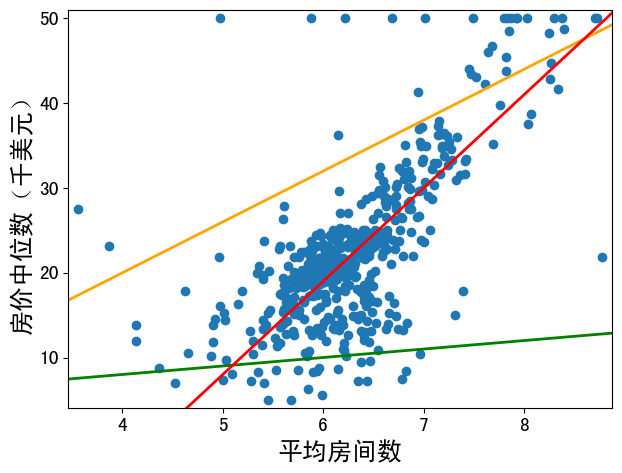

In [ ]:
def linear_fun(x, w, b):
    '''
    This a linear prediction function.
    x: feature
    b: bias
    w: weight
    '''

    y = w * x + b

    return y

fig, ax, x_linear = draw_scatter(x, y) # Plot the scatter

ax.plot(x_linear, linear_fun(x_linear, 1, 4), color='green', linewidth=2) # y = x + 4
plt.savefig('room_price_f1.png', dpi=300) # Make figure clearer

ax.plot(x_linear, linear_fun(x_linear, 6, -4), color='orange', linewidth=2) # y = 6x - 4
plt.savefig('room_price_f2.png', dpi=300) # Make figure clearer

ax.plot(x_linear, linear_fun(x_linear, 11, -47), color='red', linewidth=2) # y = 11x - 47
plt.savefig('room_price_f3.png', dpi=300) # Make figure clearer

plt.show()

练习：尝试构建其它的预测模型

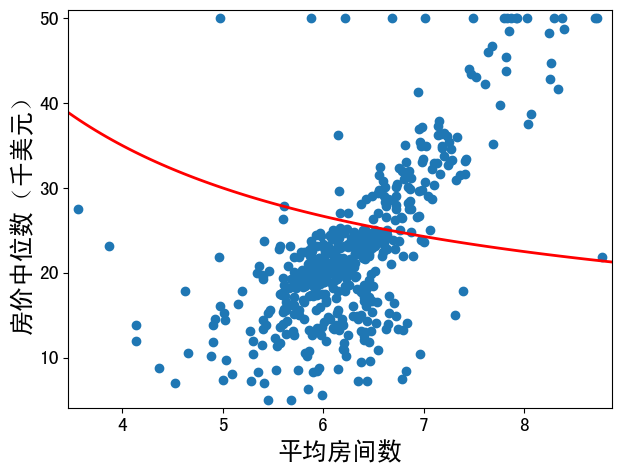

In [ ]:
def nonlinear_fun(x, w, b):
    '''
    This an example of non-linear prediction function.
    x: feature
    b: bias
    w: weight

    Return:
    y: prediction
    '''
    return w / x + b


fig, ax, x_linear = draw_scatter(x, y) # Plot the scatter
ax.plot(x_linear, nonlinear_fun(x_linear, 100, 10), color='red', linewidth=2) # 100 / x + 10
plt.show()

### 2.2.3 选择最优的房价预测模型

计算所有预测函数的损失

In [ ]:
w_min, w_max = -200, 200 # Weight range
b_min, b_max = -200, 200 # Bias range
param_num = 800 # Number of per parameter

w_list = np.linspace(w_min, w_max, param_num) # Create a sequence of w
b_list = np.linspace(b_min, b_max, param_num) # Create a sequence of b

w_grid, b_grid = np.meshgrid(w_list, b_list) # Create a grid of w and b
loss_grid = np.zeros((param_num, param_num)) # Create a grid of loss

for i in range(param_num):
    for j in range(param_num):
        # Compute loss
        y_pred = linear_fun(x, w_grid[i, j], b_grid[i, j])
        loss_temp = np.mean((y_pred - y) ** 2) / 2
        loss_grid[i, j] = loss_temp / 10 ** 5 # Scale loss for display

用热力图展示loss、w、b之间的关系，并找出最优解

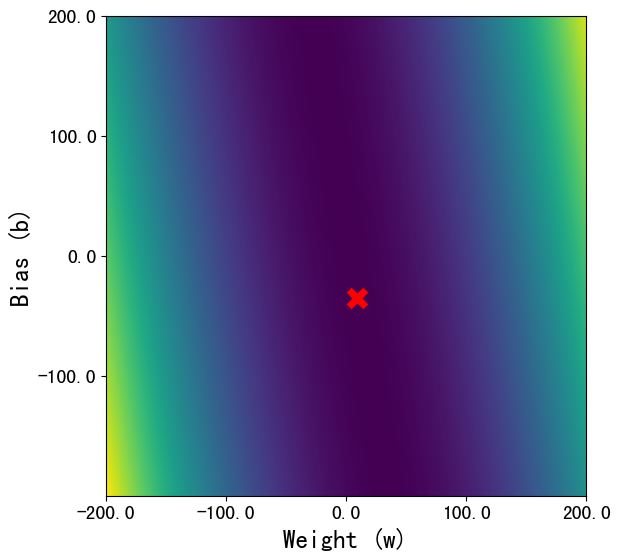

In [ ]:
# Draw heatmap first
def draw_heatmap(w_grid, b_grid, loss_grid):
    '''
    Display training process of w and b
    '''
    global label_size, ticklabel_size # Set global variables of font size

    w_min, w_max = -200, 200
    b_min, b_max = -200, 200

    # Set figure
    fig, ax = plt.subplots(figsize=(10,6))

    # Plot the loss
    im = ax.imshow(loss_grid, extent=[w_min, w_max, b_min, b_max], origin='lower', cmap='viridis', zorder=0)

    # Set x-axis and y-axis
    ax.set_xticks(np.linspace(w_min, w_max, 5))
    ax.set_xticklabels(np.linspace(w_min, w_max, 5))
    ax.set_yticks(np.linspace(b_min, b_max, 5)[1:])
    ax.set_yticklabels(np.linspace(b_min, b_max, 5)[1:])
    ax.set_xlabel('Weight (w)', fontsize=label_size)
    ax.set_ylabel('Bias (b)', fontsize=label_size)

    ax.set_xlim(w_min, w_max)
    ax.set_ylim(b_min, b_max)

    ax.set_position([0.15, 0.13, 0.60, 0.8]) # Set the position of the figure

    # Set tick label size
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

    # Mark the point of lowest loss
    min_loss_idx = np.unravel_index(np.argmin(loss_grid), loss_grid.shape)
    min_w = w_grid[min_loss_idx]
    min_b = b_grid[min_loss_idx]
    ax.scatter(min_w, min_b, color='red', marker='x', linewidth=5, s=12**2)

    return fig, ax

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid)

plt.savefig('loss_with_mark.png', dpi=300) # Make figure clearer
plt.show()

展示最优的房价预测函数

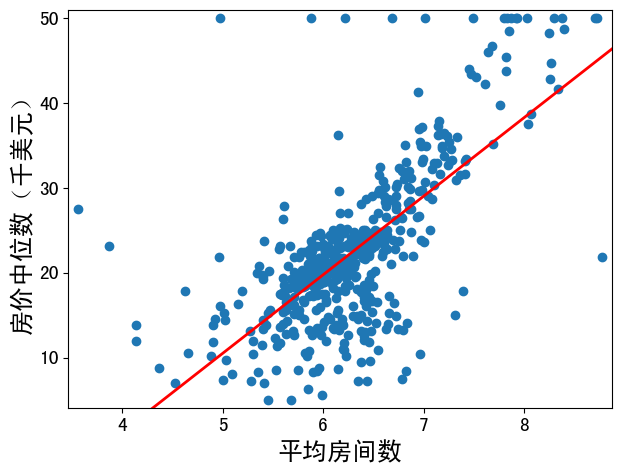

In [ ]:
'''
Drawing a figure of the best estimation function
'''

fig, ax, x_linear = draw_scatter(x, y) # Plot the scatter
ax.plot(x_linear, linear_fun(x_linear, 9.26, -35.79), color='red', linewidth=2)
plt.savefig('room_price_best.png', dpi=300) # Make figure clearer
plt.show()

## 2.3 梯度下降 Gradient Descend

本节包括两个内容：
* 梯度下降的基本逻辑
* 学习率的影响 - 练习：观察不同学习率、迭代次数条件下的训练效果
* 自适应梯度 Adaptive Gradient

### 2.3.1 梯度下降的基本逻辑

仅讨论w的变化（b=-34.67）

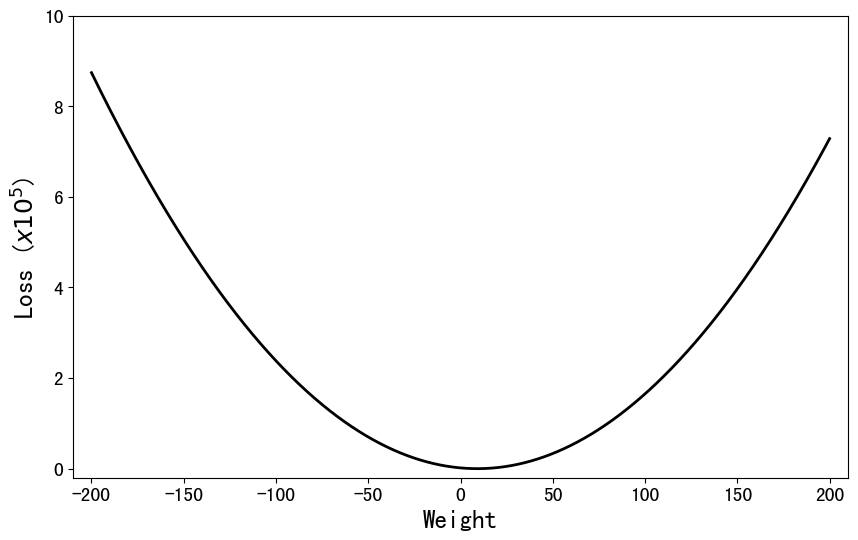

In [ ]:
def loss_w_base():
    '''
    Draw the baseline of loss function when b is -34.67
    '''
    global label_size, ticklabel_size # Set global variables of font size

    b = -34.67

    w_min, w_max = -200, 200 # Weight range
    param_num = 10000 # Number of per parameter

    w_base = np.linspace(w_min, w_max, param_num) # Create a sequence of w

    loss_base = np.zeros(param_num) # Create a grid of loss

    for i in range(param_num):
        # Compute loss
        y_pred = linear_fun(x, w_base[i], b)
        loss_base[i] = np.mean((y_pred - y) ** 2) / 2

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(w_base, loss_base / 10 ** 5, color='black', linewidth=2, zorder=0) # Scale loss for display
    ax.set_xlim(-210, 210)
    ax.set_ylim(-0.2, 10)
    ax.set_xlabel('Weight', fontsize=label_size)
    ax.set_ylabel('Loss ($x10^5$)', fontsize=label_size)
    ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

    return fig, ax

fig, ax = loss_w_base()
plt.savefig('learning_rate_base.png', dpi=300) # Make figure clearer
plt.show()

训练模型: learning rate = 0.001

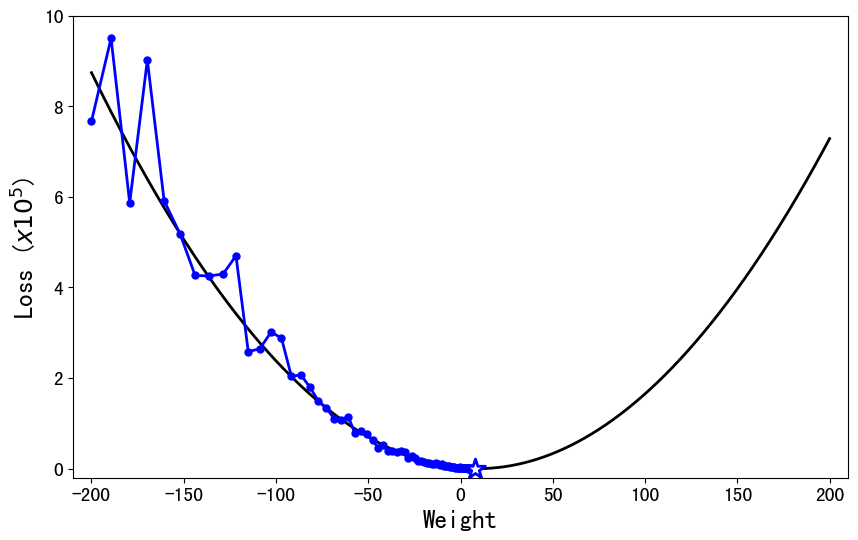

In [ ]:
def learn_w(x, y, lr=0.00001, max_epoch=100, batch_size=4, adagrad=None):
    '''
    Learning weight w with fixed bias b
    w starts with -200

    Return:
    w_list: array of w
    loss_list: array of loss
    '''
    w = -200 # Set initial value of w
    b = -34.67 # Fixed bias

    w_list = [w] # Create a list to store w
    loss_list = [] # Create a list to store loss

    # Training
    for ie in range(max_epoch):
        # Shuffle x
        idx = np.random.permutation(x.shape[0])

        # Update learning rate
        if adagrad == 'temporal':
            lr = lr / np.sqrt(ie+1) # Update learning rate

        # Split indices into batches
        dw = 0
        for ib in range(0, x.shape[0], batch_size):
            batch_idx = idx[ib:ib+batch_size]
            x_batch = x[batch_idx]
            y_batch = y[batch_idx]

            y_batch_pred = linear_fun(x_batch, w, b)

            dw = dw + np.mean((y_batch_pred - y_batch) * x_batch) # Compute partial derivative of w

        w -= lr * dw # Update w

        loss_list.append(np.mean((y_batch_pred - y_batch) ** 2) / 2) # Compute and record loss
        w_list.append(w)

    # Final loss
    y_pred = linear_fun(x, w, b)
    loss_list.append(np.mean((y - y_pred) ** 2) / 2) # Compute and record loss

    w_list = np.array(w_list)
    loss_list = np.array(loss_list) / 10 ** 5

    return w_list, loss_list

def add_loss_w(fig, ax, w_list, loss_list):
    global label_size, ticklabel_size # Set global variables of font size

    # Plot training losses
    ax.plot(w_list, loss_list / 10 ** 5, color='blue', linewidth=2, zorder=1)
    ax.legend(ncol=2, fontsize=label_size)

    # Mark final place
    ax.scatter(w_list[-1], loss_list[-1] / 10 ** 5, s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

    return fig, ax

# Display training result of lr = 0.001
lr = 0.00001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses

ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

plt.savefig('learning_rate_D00001.png', dpi=300) # Make figure clearer
plt.show()

以较小的学习率训练模型

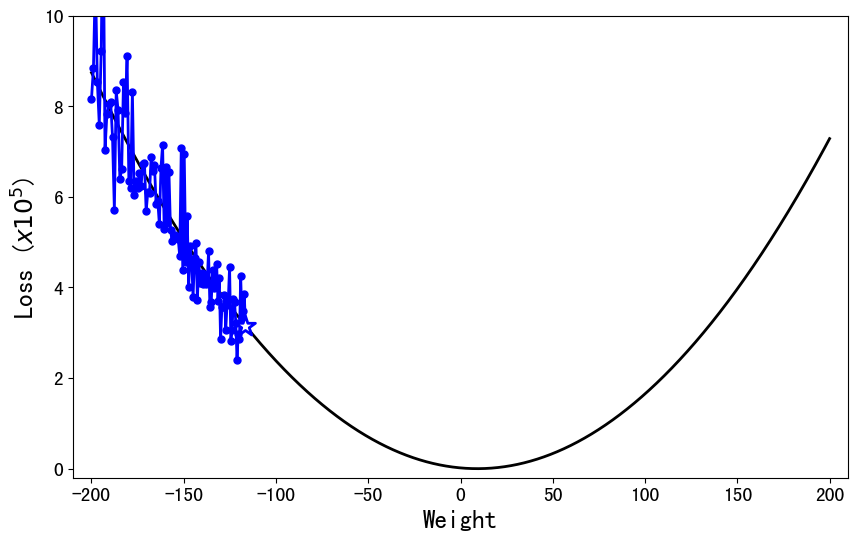

In [ ]:
lr = 0.000001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

plt.savefig('learning_rate_D000001.png', dpi=300) # Make figure clearer
plt.show()

以更小的学习率训练模型

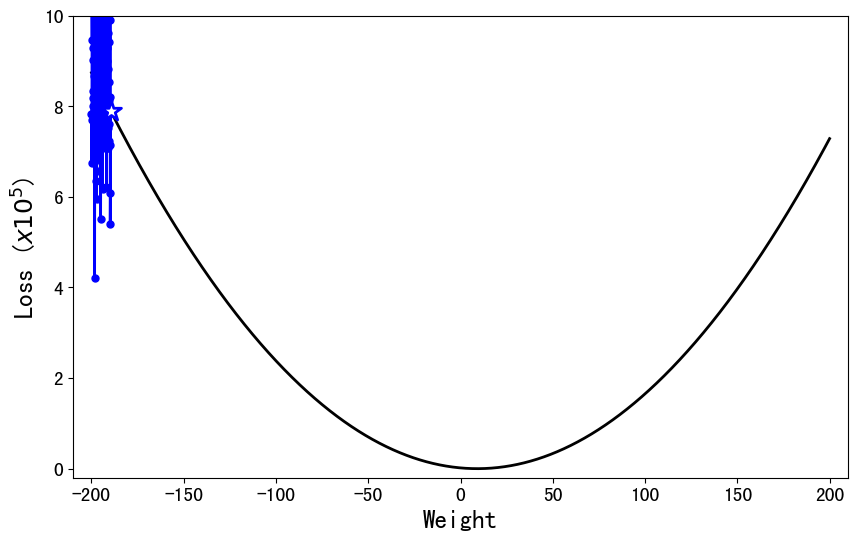

In [ ]:
lr = 0.0000001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

plt.savefig('learning_rate_D0000001.png', dpi=300) # Make figure clearer
plt.show()

以较大的学习率训练模型

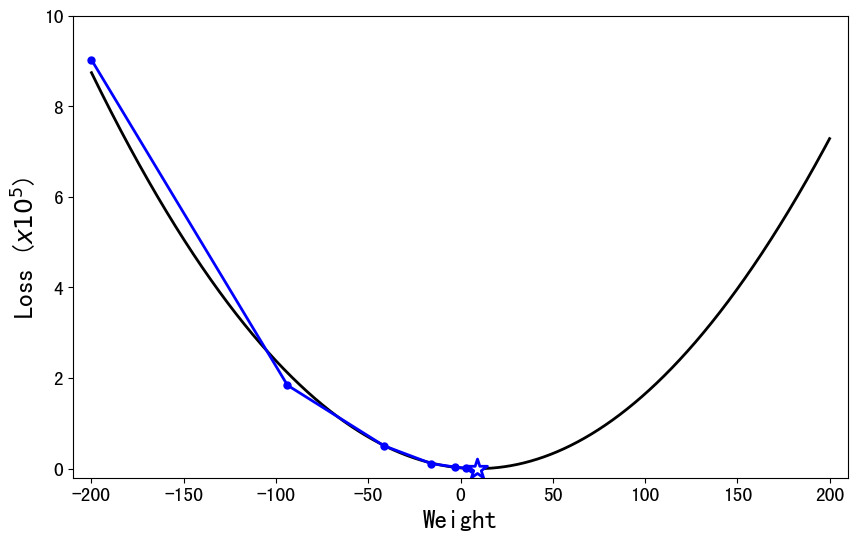

In [ ]:
lr = 0.0001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

plt.savefig('learning_rate_D0001.png', dpi=300) # Make figure clearer
plt.show()

以更大的学习率训练模型

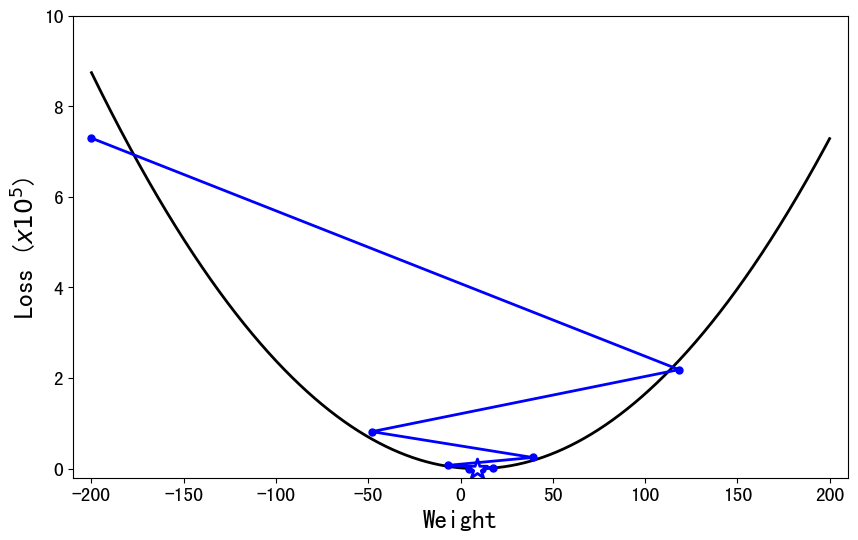

In [ ]:
lr = 0.0003 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
ax.plot(w_list, loss_list, color='blue', marker='.', markersize=10, linewidth=2, zorder=1) # Plot training losses
ax.scatter(w_list[-1], loss_list[-1], s=15**2, marker='*', facecolor='white', edgecolor='blue', linewidth=2, zorder=2)

plt.savefig('learning_rate_D0003.png', dpi=300) # Make figure clearer
plt.show()

以更更大的学习率训练模型

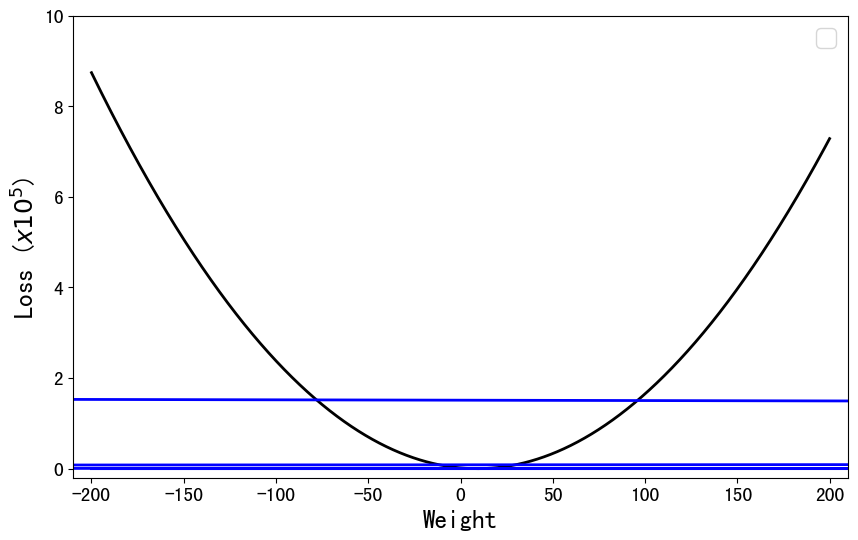

In [ ]:
lr = 0.001 # Set learning rate

w_list, loss_list = learn_w(x, y, lr) # Training model
fig, ax = loss_w_base() # Draw base losses
fig, ax = add_loss_w(fig, ax, w_list, loss_list) # Add training losses

plt.savefig('learning_rate_D001.png', dpi=300) # Make figure clearer
plt.show()

### 2.3.2 练习：观察不同学习率和迭代次数条件下的结果

In [ ]:
def compute_loss_and_derivative(x, y, w, b):
    '''
    This a linear prediction function.

    Return loss, dw, db:
    loss: loss of the prediction
    dw: partial derivative of w
    db: partial derivative of b
    '''
    pass

def init_param():
    '''
    This a linear prediction function.

    Return w, b:
    w: weight
    b: bias
    '''
    pass

def train_linear_fun(x, y, lr, num_iter):
    '''
    This a linear prediction function.

    Return training log including losses and parameters:
    loss_list: list of losses
    param_list: list of parameters
    '''
    pass

# Training models in different conditions

### 2.3.4 自适应梯度


同时对w和b进行更新

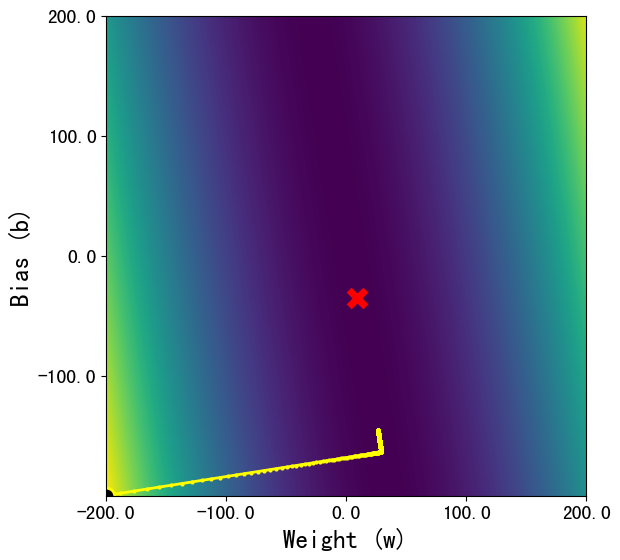

In [ ]:
def learn_w_b(x, y, lr=0.0001, max_epoch=100000, batch_size=4, adagrad=False):
    '''
    Learning weight w and bias b
    (w, b) starts with (-200, -200)

    Return:
    w_list: array of w
    b_list: array of b
    loss_final: final loss
    '''
    # Initialize parameters
    w, b = -200, -200

    if adagrad == True:
        lr_w = 0.0
        lr_b = 0.0

    # Model training process
    w_list = [w] # Create a list to store w
    b_list = [b] # Create a list to store b
    for ie in range(max_epoch):
        # Shuffle x
        idx = np.random.permutation(x.shape[0])

        # Split indices into batches
        dw, db = 0, 0
        for ib in range(0, x.shape[0], batch_size):
            batch_idx = idx[ib:ib+batch_size]
            x_batch = x[batch_idx]
            y_batch = y[batch_idx]

            y_batch_pred = linear_fun(x_batch, w, b)

            dw = dw + np.mean((y_batch_pred - y_batch) * x_batch) # Compute partial derivative of w
            db = db + np.mean((y_batch_pred - y_batch) * 1.0) # Compute partial derivative of b

        if adagrad == True:
            lr_w = lr_w + dw ** 2
            lr_b = lr_b + db ** 2

            w -= lr / np.sqrt(lr_w) * dw # Update w
            b -= lr / np.sqrt(lr_b) * db # Update d

        else:
            w -= lr * dw # Update w
            b -= lr * db # Update d

        w_list.append(w)
        b_list.append(b)

    # Change list into array for plotting
    w_list = np.array(w_list)
    b_list = np.array(b_list)

    # Final loss
    y_pred = linear_fun(x, w, b)
    loss_final = np.mean((y - y_pred) ** 2) / 2 # Compute and record loss

    return w_list, b_list, loss_final

w_list, b_list, loss_final = learn_w_b(x, y, lr=0.00001, max_epoch=10000)

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid) # Draw base image
ax.plot(w_list, b_list, color='yellow', marker='.', linewidth=2, markersize=4, zorder=1) # Plot training losses
ax.scatter(w_list[0], b_list[0], color='yellow', facecolor='black', marker='o', linewidth=2, s=12**2, zorder=2) # Add start place

plt.savefig('f2_learning_rate_D00001.png', dpi=300) # Make figure clearer
plt.show()

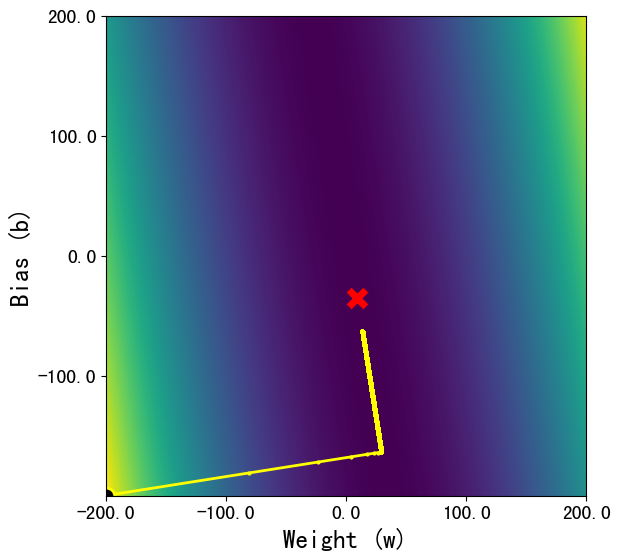

In [ ]:
w_list, b_list, loss_final = learn_w_b(x, y, lr=0.0001, max_epoch=10000)

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid) # Draw base image
ax.plot(w_list, b_list, color='yellow', marker='.', linewidth=2, markersize=4, zorder=1) # Plot training losses
ax.scatter(w_list[0], b_list[0], color='yellow', facecolor='black', marker='o', linewidth=2, s=12**2, zorder=2) # Add start place

plt.savefig('f2_learning_rate_D0001.png', dpi=300) # Make figure clearer
plt.show()

<ipython-input-70-24016dff415a>:34: RuntimeWarning: overflow encountered in scalar add
  dw = dw + np.mean((y_batch_pred - y_batch) * x_batch) # Compute partial derivative of w
<ipython-input-70-24016dff415a>:45: RuntimeWarning: invalid value encountered in scalar subtract
  w -= lr * dw # Update w


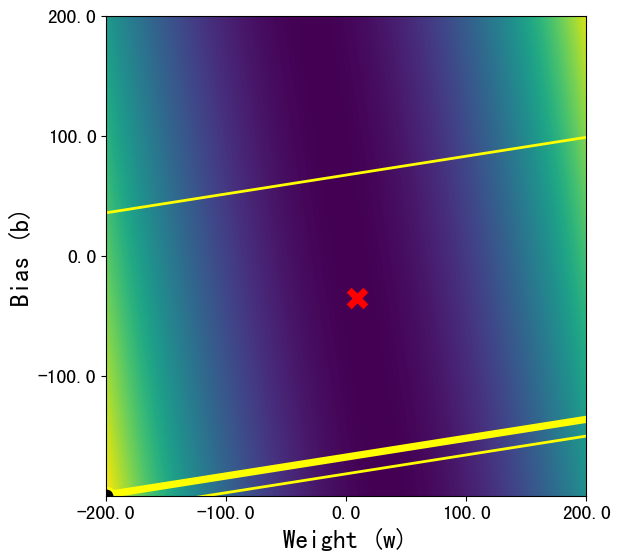

In [ ]:
w_list, b_list, loss_final = learn_w_b(x, y, lr=0.001, max_epoch=10000)

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid) # Draw base image
ax.plot(w_list, b_list, color='yellow', marker='.', linewidth=2, markersize=4, zorder=1) # Plot training losses
ax.scatter(w_list[0], b_list[0], color='yellow', facecolor='black', marker='o', linewidth=2, s=12**2, zorder=2) # Add start place

plt.savefig('f2_learning_rate_D001.png', dpi=300) # Make figure clearer
plt.show()

让学习率随时间减小

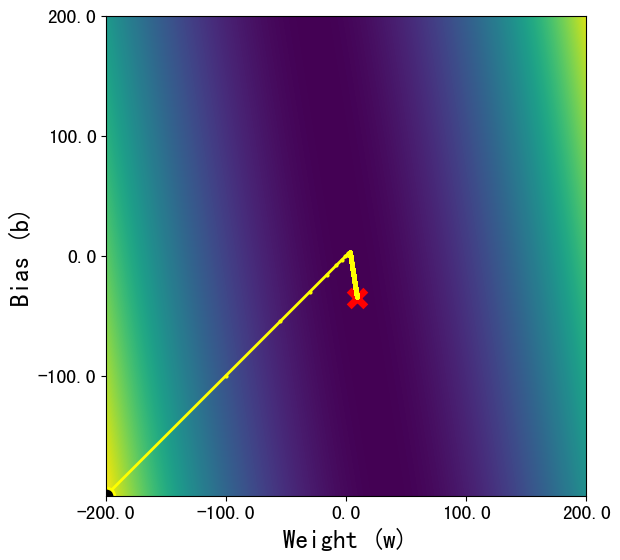

In [ ]:
w_list, b_list, loss_final = learn_w_b(x, y, lr=100, max_epoch=10000, adagrad=True)

fig, ax = draw_heatmap(w_grid, b_grid, loss_grid) # Draw base image
ax.plot(w_list, b_list, color='yellow', marker='.', linewidth=2, markersize=4, zorder=1) # Plot training losses
ax.scatter(w_list[0], b_list[0], color='yellow', facecolor='black', marker='o', linewidth=2, s=12**2, zorder=2) # Add start place

plt.savefig('f2_Adagrad_D001.png', dpi=300) # Make figure clearer
plt.show()

## 2.4 模型泛化 Generalization

构建数据集与测试集，观察模型复杂度与预测结果的关系

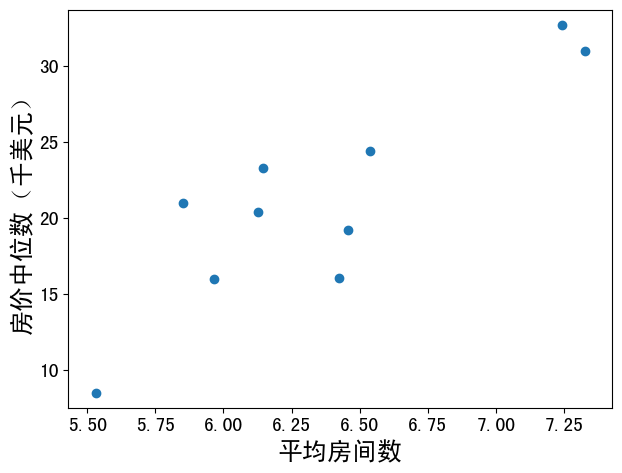

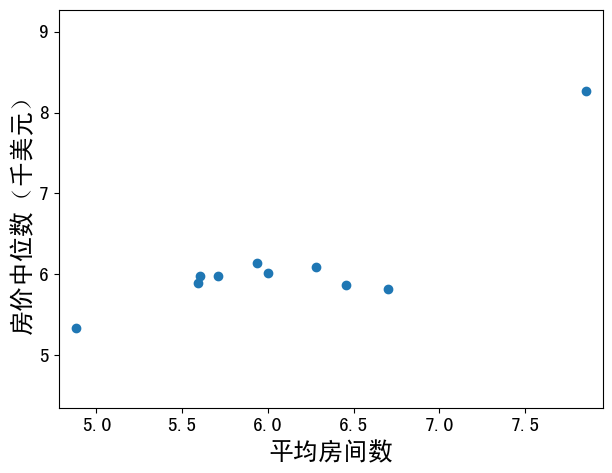

In [ ]:
from sklearn.model_selection import train_test_split

def normalization(x, norm_type='min-max'):
    '''
    Normalization
    '''
    if norm_type == 'min-max':
        a, b = np.min(x), np.max(x)
        x_norm = (x - a) / (b - a)
        return x_norm, a, b

    elif norm_type == 'z-score':
        a, b = np.mean(x), np.std(x)
        x_norm = (x - a) / b
        return x_norm, a, b

def norm_recover(x_norm, a, b, norm_type='min-max'):
    '''
    Normalization
    '''
    if norm_type == 'min-max':
        x = x_norm * (b - a) + a
        return x

    elif norm_type == 'z-score':
        x = x_norm * b + a
        return x

norm_type = 'z-score'

# Normalization
x_norm, x_a, x_b = normalization(x, norm_type=norm_type)
y_norm, y_a, y_b = normalization(y, norm_type=norm_type)

# Split data into training and testing domains (Not for this section)
X_train, X_test, Y_train, Y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)

num_samples = 10
np.random.seed(42) # Set the random seed for reproducibility
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)
x_train = X_train[random_indices]
y_train = Y_train[random_indices]

x_train_scatter = norm_recover(x_train, x_a, x_b, norm_type=norm_type)
y_train_scatter = norm_recover(y_train, y_a, y_b, norm_type=norm_type)

# np.random.seed(42) # Set the random seed for reproducibility
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
x_test = X_test[random_indices]
y_test = Y_test[random_indices]

x_test_scatter = norm_recover(x_test, x_a, x_b, norm_type=norm_type)
y_test_scatter = norm_recover(y_test, x_a, x_b, norm_type=norm_type)

# Plot the training data
fig, ax, _ = draw_scatter(x_train_scatter, y_train_scatter)
plt.savefig('scatter_train_data.png', dpi=300) # Make figure clearer

# Plot the testing data
fig, ax, _ = draw_scatter(x_test_scatter, y_test_scatter)
plt.savefig('scatter_test_data.png', dpi=300) # Make figure clearer

In [ ]:
def train_poly_mdl(x, y, lr=100, max_epoch=1000000, batch_size=1, p=1):
    '''
    Learning weight w and bias b
    p is the order of polynomial

    Return:
    w_list: array of w
    b_list: array of b
    err_train: prediction accuracy
    '''
    global norm_type

    # Initialize w, b, and exponential x
    w = np.random.randn(p) * 100
    b = 0.0

    x = [x ** (i+1) for i in range(p)]
    x = np.array(x).T

    # Initialize learning rate
    lr_w = np.zeros(w.size)
    lr_b = 0.0

    # Model training process
    for ie in range(max_epoch):

        idx = np.random.permutation(x.shape[0]) # Shuffle x

        dw = np.zeros(w.size)
        db = 0.0

        for ib in range(0, x.shape[0], batch_size):
            batch_idx = idx[ib:ib+batch_size]
            x_batch = x[batch_idx, :]
            y_batch = y[batch_idx]

            y_batch_pred = np.matmul(x_batch, w) + b

            # Compute partial derivative of w and b
            for i in range(w.size):
                dw[i] = dw[i] + np.mean((y_batch_pred - y_batch) * x_batch[:, i])
            db = db + np.mean((y_batch_pred - y_batch) * 1.0) # Compute partial derivative of b

        # # Adagrad
        lr_w = lr_w + dw ** 2
        lr_b = lr_b + db ** 2

        w -= lr / np.sqrt(lr_w) * dw # Update w
        b -= lr / np.sqrt(lr_b) * db # Update d

    # Predict error
    y_pred = np.matmul(x, w) + b
    err = np.mean(np.abs(norm_recover(y, y_a, y_b, norm_type=norm_type) - norm_recover(y_pred, y_a, y_b, norm_type=norm_type))) # Train error

    return w, b, err

p_list = range(1, 11, 1) # Set the order of polynomial
param_list = []
err_list = []

for p in p_list:
    # Train model
    w, b, err_train = train_poly_mdl(x_train, y_train, p=p, lr=100, max_epoch=1000000, batch_size=num_samples)
    param_list.append((w, b))

    x_test_exp = [x_test ** (i+1) for i in range(p)]
    x_test_exp = np.array(x_test_exp).T
    y_test_pred = np.matmul(x_test_exp, w) + b
    err_test = np.mean(np.abs(norm_recover(y_test, y_a, y_b, norm_type=norm_type) - norm_recover(y_test_pred, y_a, y_b, norm_type=norm_type))) # Train error

    err_list.append((err_train, err_test))

    print(f'p={p}\t Training avg_err: {err_train}\t Testing avg_err: {err_test}')

p=1	 Training avg_err: 2.8898418256399423	 Testing avg_err: 4.9989056220327
p=2	 Training avg_err: 2.86878856935306	 Testing avg_err: 5.1824471458777435
p=3	 Training avg_err: 2.4947969414931555	 Testing avg_err: 9.77627424510311
p=4	 Training avg_err: 1.8300068207967406	 Testing avg_err: 27.69356895858944
p=5	 Training avg_err: 1.852491733665083	 Testing avg_err: 26.481112196836847
p=6	 Training avg_err: 1.7256843045454509	 Testing avg_err: 138.62351991486435
p=7	 Training avg_err: 0.850843543369568	 Testing avg_err: 5554.649907268612
p=8	 Training avg_err: 0.952305520783073	 Testing avg_err: 5266.325611014795
p=9	 Training avg_err: 4.653663283394996	 Testing avg_err: 5431.322000577531
p=10	 Training avg_err: 5.744607347271327	 Testing avg_err: 82566.52369362928


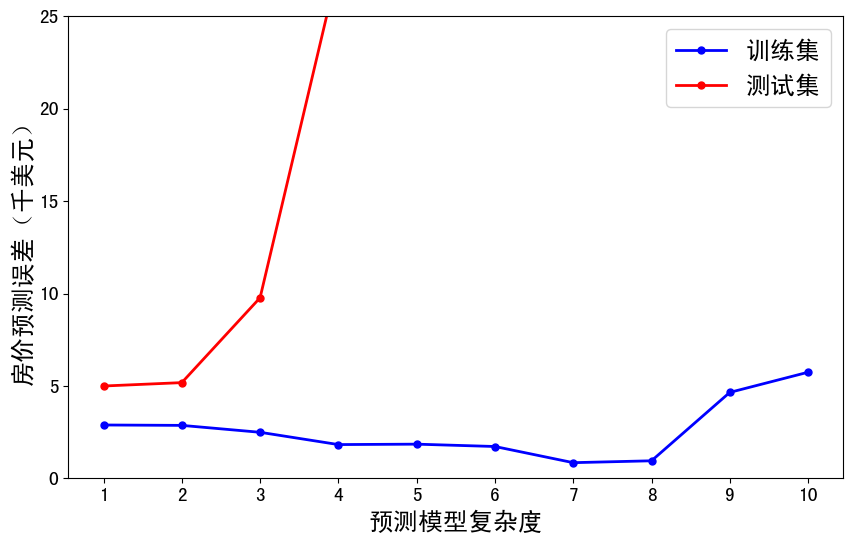

In [ ]:
err_list = np.array(err_list)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(p_list, err_list[:, 0], color='blue', marker='.', markersize=10, linewidth=2, zorder=1, label='训练集') # Plot training losses
plt.plot(p_list, err_list[:, 1], color='red', marker='.', markersize=10, linewidth=2, zorder=1, label='测试集') # Plot training losses
plt.legend(ncol=1, fontsize=label_size)

ax.set_xticks(p_list)
ax.set_ylim(0, 25)

ax.set_xlabel('预测模型复杂度', fontsize=label_size)
ax.set_ylabel('房价预测误差（千美元）', fontsize=label_size)
ax.tick_params(axis='both', which='major', labelsize=ticklabel_size)

plt.savefig('complexity_vs_error.png', dpi=300) # Make figure clearer

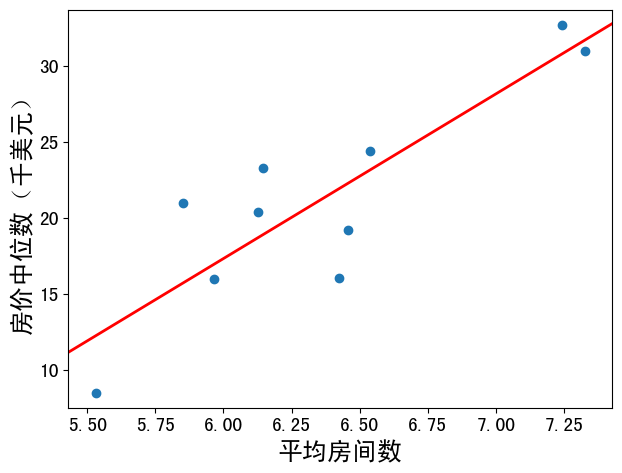

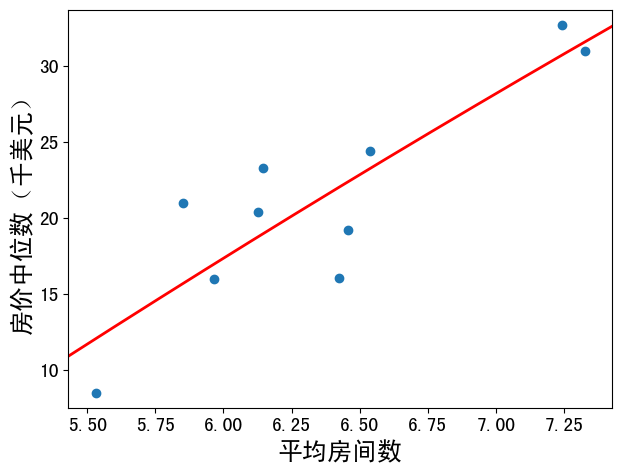

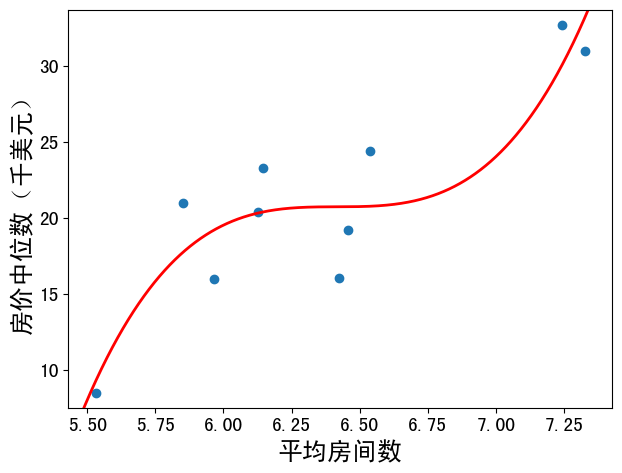

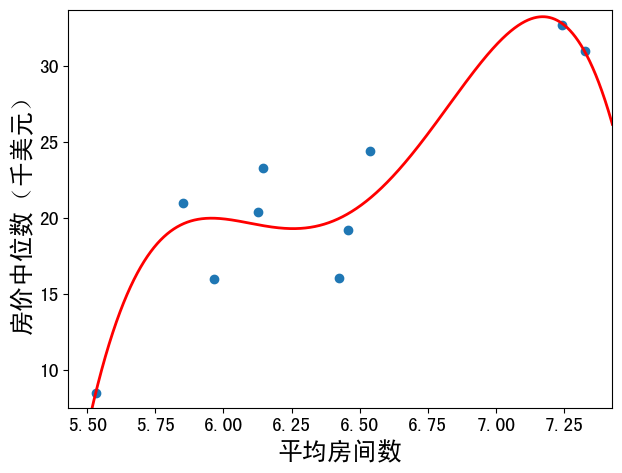

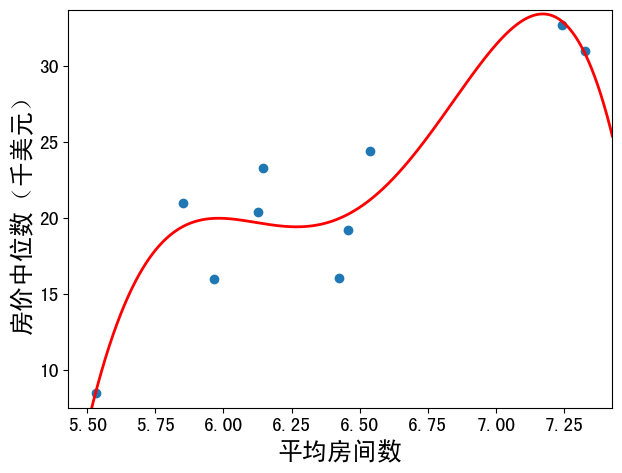

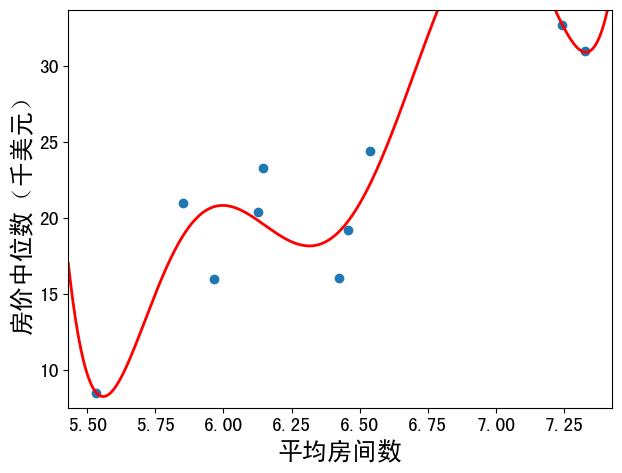

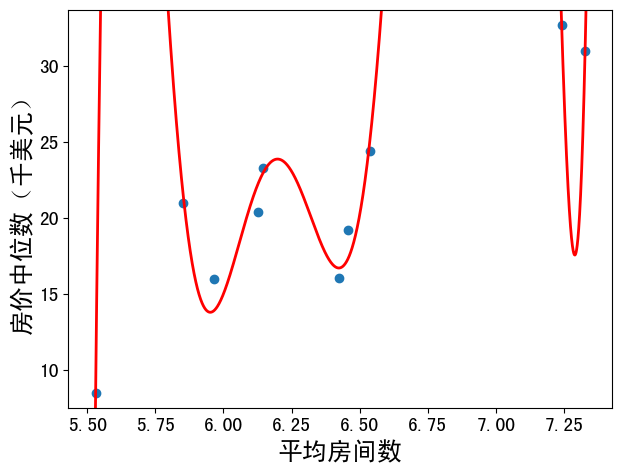

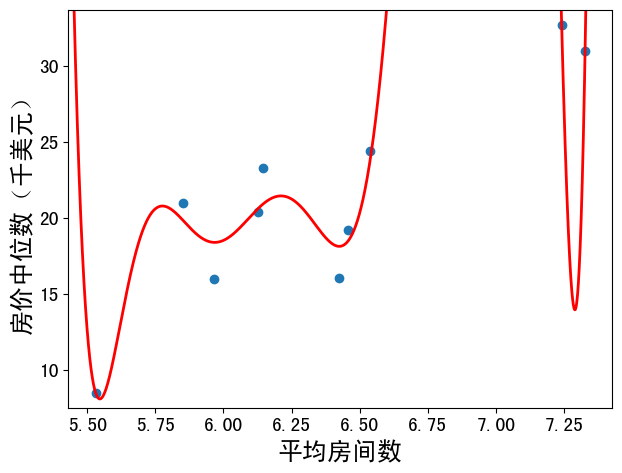

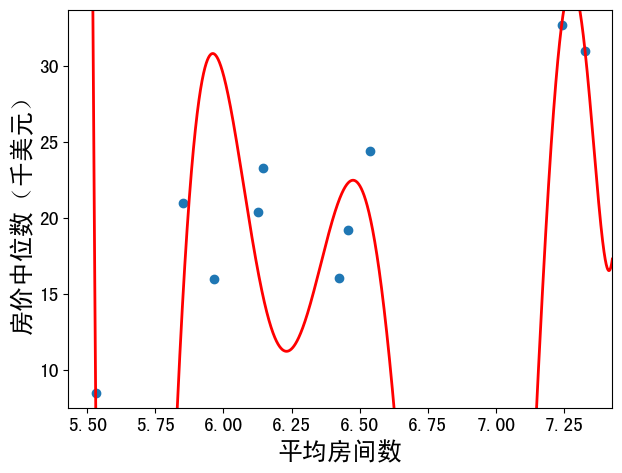

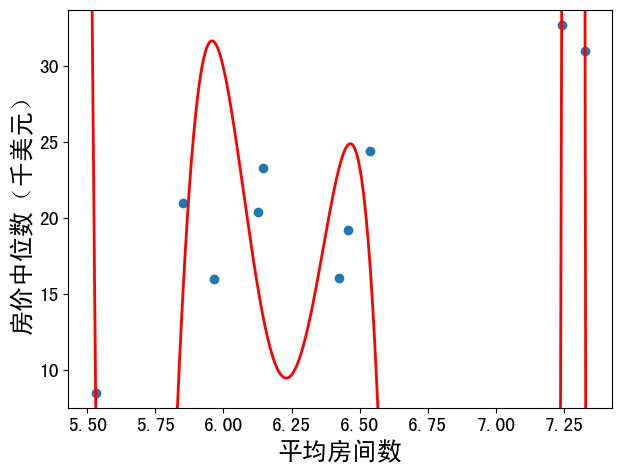

In [ ]:
x_linear = np.linspace(-2, 2, 10000) # Create a sequence of x to draw prediction function

x_linear_scatter = norm_recover(x_linear, x_a, x_b, norm_type=norm_type)

for i in range(len(p_list)):
    p = p_list[i]
    w, b = param_list[i]

    # Draw prediction function
    fig, ax, _ = draw_scatter(x_train_scatter, y_train_scatter) # Plot the scatter

    x_linear_exp = [x_linear ** (i+1) for i in range(p)]
    x_linear_exp = np.array(x_linear_exp).T

    y_linear = np.matmul(x_linear_exp, w) + b
    y_linear_scatter = norm_recover(y_linear, y_a, y_b, norm_type=norm_type)

    ax.plot(x_linear_scatter, y_linear_scatter, color='red', linewidth=2)

    plt.savefig(f'polylinearfit_p{p}.png', dpi=300) # Make figure clearer
    plt.show()

## 2.6 实验：基于线性回归的房价预测

此部分需要同学自行完成各个任务要求，训练并评估房价预测模型：
* 数据读取及预处理
* 模型设计：线性模型、非线性模型
* 损失函数设计
* 模型训练：梯度下降、交叉验证法
* 结果展示与分析：学习曲线